In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc

In [2]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
dftrain

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,female,19.0,0,0,30.0000,First,B,Southampton,y
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


In [4]:
dftrain.head()


,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


<AxesSubplot:>

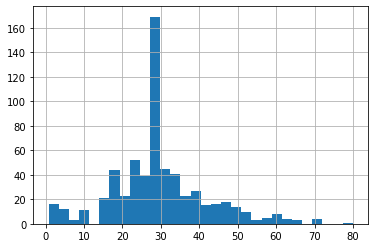

In [6]:
dftrain.age.hist(bins=30)

<AxesSubplot:>

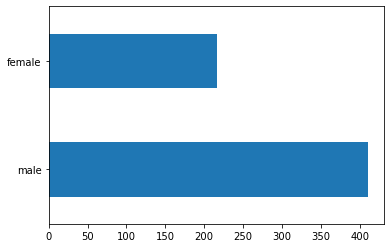

In [7]:
dftrain.sex.value_counts().plot(kind='barh')

In [8]:
categories = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
numerical = ['age', 'fare']


In [10]:
feature_columns = []
for feature_name in categories:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

In [11]:
for feature_name in numerical:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [14]:
# inspect the data
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())
    

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'Third' b'Third' b'Third' b'Second' b'First' b'Third' b'Third'
 b'Third' b'First']

A batch of Labels: [1 1 0 0 0 1 0 1 0 1]


In [15]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


array([[32.],
       [28.],
       [28.],
       [28.],
       [30.],
       [48.],
       [35.],
       [25.],
       [28.],
       [40.]], dtype=float32)

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.8279462, 'auc_precision_recall': 0.7962052, 'average_loss': 0.49370974, 'label/mean': 0.375, 'loss': 0.4877626, 'precision': 0.6454545, 'prediction/mean': 0.44511315, 'recall': 0.7171717, 'global_step': 200}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\vinay\AppData\Local\Temp\tmpuu1cnr30\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

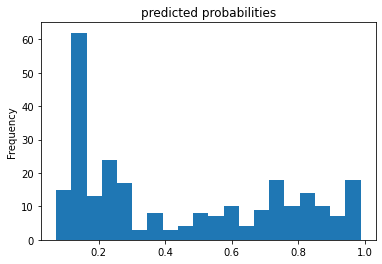

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

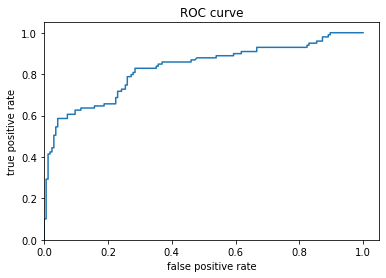

In [19]:
# ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)